playing with image embeddings

In [8]:
from google.colab import auth
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
import os
import tensorflow_datasets as tfds
from sklearn.decomposition import PCA

In [2]:
auth.authenticate_user()

In [3]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
#gsutil -u [PROJECT_ID] cp gs://[BUCKET_NAME]/[OBJECT_NAME] [OBJECT_DESTINATION]
# chest x rays not embeddings
# !gsutil -u "leafy-thunder-378001" cp -r gs://mimic-cxr-2.0.0.physionet.org ./

Copying gs://mimic-cxr-2.0.0.physionet.org/cxr-record-list.csv.gz...
Caught CTRL-C (signal 2) - exiting
^C


In [41]:
# embeddings only
!gsutil cp -r gs://image-embeddings-mimic-cxr-1.0.physionet.org ./
# hospital mimic iv - admissions=race, patients = gender

Copying gs://image-embeddings-mimic-cxr-1.0.physionet.org/LICENSE.txt...
Copying gs://image-embeddings-mimic-cxr-1.0.physionet.org/SHA256SUMS.txt...
Copying gs://image-embeddings-mimic-cxr-1.0.physionet.org/files/p10/p10000032/s50414267/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.tfrecord...
Copying gs://image-embeddings-mimic-cxr-1.0.physionet.org/files/p10/p10000032/s53189527/2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab.tfrecord...
- [4 files][ 34.6 MiB/ 34.6 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://image-embeddings-mimic-cxr-1.0.physionet.org/files/p10/p10000032/s53911762/68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714.tfrecord...
Copying gs://image-embeddings-mimic-cxr-1.0.physionet.org/files/p10/p10000032/s5391

In [4]:
# need to davigate using cxr-record-list.csv.gz from CXR - .tfrecords instead of .dcm
# also add admissions and patients to files
!gsutil -u "leafy-thunder-378001" cp gs://mimic-cxr-2.0.0.physionet.org/cxr-record-list.csv.gz ./

Copying gs://mimic-cxr-2.0.0.physionet.org/cxr-record-list.csv.gz...
/ [1 files][ 14.2 MiB/ 14.2 MiB]                                                
Operation completed over 1 objects/14.2 MiB.                                     


In [111]:
# read embeddings into tf Dataset
filenames = []
for root, dirs, files in os.walk('/content/embeddings/files/p10'):
    for file in files:
        if file.endswith('.tfrecord'):
            filenames.append(os.path.join(root, file))
print(filenames)
raw_dataset = tf.data.TFRecordDataset(filenames)

['/content/embeddings/files/p10/p10062617/s59986994/94e15f36-52b48fdc-58296169-e01f7115-832352b3.tfrecord', '/content/embeddings/files/p10/p10062617/s50247193/b9074a5c-7eef626c-4b251438-c744a7ea-163aade8.tfrecord', '/content/embeddings/files/p10/p10062617/s58274130/f32bb62b-a3cc1c12-45d718da-c9e95717-a880fa08.tfrecord', '/content/embeddings/files/p10/p10062617/s55170181/5b8f4e5f-074a3958-ca8e7fc2-100ffa07-6f553e72.tfrecord', '/content/embeddings/files/p10/p10062617/s55170181/70ecd4c6-f76bee83-00e33416-7bce2ca0-95211525.tfrecord', '/content/embeddings/files/p10/p10062617/s50346563/61609ae0-903e4faa-9f2bf1b9-34fff3a8-fcaa3ba7.tfrecord', '/content/embeddings/files/p10/p10062617/s50346563/de1ce057-94740c67-535d6c35-eec8e1bb-060925ea.tfrecord', '/content/embeddings/files/p10/p10062617/s53916328/b55e6837-0b54709c-8bd6056f-5f86a5c5-1664b722.tfrecord', '/content/embeddings/files/p10/p10062617/s53916328/c7e7cc13-bdf3d9fa-fcda409e-c536d9ce-d0c1a9fc.tfrecord', '/content/embeddings/files/p10/p1006

In [112]:
for raw_record in raw_dataset.take(10):
  print(repr(raw_record))

<tf.Tensor: shape=(), dtype=string, numpy=b'\n\xaf,\n}\n\x08image/id\x12q\no\nmgs://superrad/inputs/mimic-cxr/files/p10/p10062617/s59986994/94e15f36-52b48fdc-58296169-e01f7115-832352b3.dcm\n\x94+\n\tembedding\x12\x86+\x12\x83+\n\x80+X\nd?@\xb1\x1f\xbf\xb8\x06\xf1>\x9c\xcfM\xc0$\x0b\x1c?x\xab6>h\xf8\xa8\xbe\x80]\xb1?\xcf\xfb5=Fp<?a\x90|\xbf\x0f^??Mz\x15=\xfdg\x1d\xbfo\x1b\n@\xc8\x1eb?d\x02\x8f\xbfM\xfa\xed?\xbb\xde\xdc=\x1b\xcf\xc2?\x01]\x13?\xa8~\xf0>\x0b\x01\x99\xbf\xac"\xca?/B\x19\xbe\x1b\xbb@?w\xf0e\xbf\xd6\x9cC\xc0fh\xf4\xbf\x89\xbf\xff?\xff\xe4\x08\xc0\xa0)\xd2\xbf\xb8\xd2t\xbdT\xb8\x14\xbf\xde\xfc \xbf4<\xff\xbe\xaa\xa3\x1f?tD\xbb\xbf\xc1n\x92\xc0\x01d\x17\xc0\xc3\x1b\xed>\xca\xa4\xfb\xbe\xcd(\xb4>!\x00\x05\xbe\x16\xcdy?M\x94\x9b?\xa1\xd8\xd9?!\xda;\xc0F\xc9\x92?2NS\xbe\xbdL\x18\xbe\xb3\xb5\x14\xbf\xf5\x8a\x0b@O\x9c\x13?\xdd\xed\xc7?Z M?\xb4\xb1M?\x84\xbb\r@\xdb\xda\xe2\xbf**\x81\xbf\xefi\x9b>C\x13\x0f\xc0\xe8#\x14?\x00Q\\\xbf\x9c\xdd\x0f@\x8a\xf2\x87?\xf4\xf7\xe0?Xa\x7f?\xdc\x9e

In [60]:
# Create a description of the features.
feature_description = {
    'embedding': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing = True, default_value=0.0)
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

In [107]:
parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset

<MapDataset element_spec={'embedding': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}>

In [108]:
for parsed_record in parsed_dataset.take(10):
  print(repr(parsed_record))

In [109]:
df = tfds.as_dataframe(parsed_dataset)

In [122]:
len(df.loc[1]['embedding'])

KeyError: ignored

In [74]:
df2 = pd.DataFrame(df['embedding'].to_list())

In [76]:
df2.loc[1]

0       0.053612
1      -0.961859
2       1.428203
3      -1.297051
4       0.610378
          ...   
1371    1.538535
1372    1.435946
1373   -2.013667
1374   -0.171520
1375   -1.171209
Name: 1, Length: 1376, dtype: float32

In [79]:
pca = PCA(n_components=2)
pca.fit(df2)

PCA(n_components=2)

<AxesSubplot:xlabel='first', ylabel='second'>

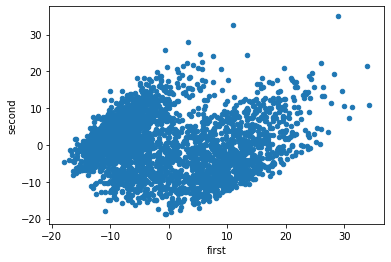

In [80]:
df3 = pd.DataFrame(pca.transform(df2), columns = ['first', 'second'])
df3.plot.scatter(x = 'first', y = 'second')

Visualize clustering of embeddings with colorings for condition

In [123]:
# dataframe: path2record (to get embeddings) - race (admissions), insurance i.e. medicaid (admissions), gender(patients), age (patients), condition?
df_admissions = pd.read_csv('admissions.csv.gz')[['subject_id', 'insurance', 'race']]
df_patients = pd.read_csv('patients.csv.gz')[['subject_id', 'gender', 'anchor_age']]
df_cxr = pd.read_csv('cxr-record-list.csv.gz')[['subject_id', 'path']]
df = pd.merge(df_admissions, df_patients, on='subject_id', how='outer')
df = pd.merge(df, df_cxr, on='subject_id', how='right')

In [35]:
# note inconsistancies in insurance
df

,subject_id,insurance,race,gender,anchor_age,path
0,10000032,Other,WHITE,F,52.0,files/p10/p10000032/s50414267/02aa804e-bde0afd...
1,10000032,Medicaid,WHITE,F,52.0,files/p10/p10000032/s50414267/02aa804e-bde0afd...
2,10000032,Medicaid,WHITE,F,52.0,files/p10/p10000032/s50414267/02aa804e-bde0afd...
3,10000032,Medicaid,WHITE,F,52.0,files/p10/p10000032/s50414267/02aa804e-bde0afd...
4,10000032,Other,WHITE,F,52.0,files/p10/p10000032/s50414267/174413ec-4ec4c1f...
...,...,...,...,...,...,...
2556266,19999733,Other,WHITE,F,19.0,files/p19/p19999733/s57132437/428e2c18-5721d8f...
2556267,19999733,Other,WHITE,F,19.0,files/p19/p19999733/s57132437/58c403aa-35ff8bd...
2556268,19999987,Other,UNKNOWN,F,57.0,files/p19/p19999987/s55368167/58766883-376a15c...
2556269,19999987,Other,UNKNOWN,F,57.0,files/p19/p19999987/s58621812/7ba273af-3d290f8...


In [ ]:
# Create a description of the features.
feature_description = {
    'embedding': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing = True, default_value=0.0)
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

# get embeddings
df_embeddings = pd.DataFrame(index=df.index)
indices = []
filenames = []
for i in range(df_embeddings.shape[0]):
  path = "/content/embeddings/" + str(df.loc[i]['path'])[:-3] + 'tfrecord'
  if os.path.isfile(path):
    filenames.append(path)
    indices.append(i)

In [128]:
raw_dataset = tf.data.TFRecordDataset(filenames)
parsed_dataset = raw_dataset.map(_parse_function)
df_embeddings = tfds.as_dataframe(parsed_dataset)
df_embeddings = pd.DataFrame(df_embeddings['embedding'].to_list())

In [129]:
df_embeddings

Empty StyledDataFrame
Columns: []
Index: []

In [ ]:
pca = PCA(n_components=2)
pca.fit(df2)

In [ ]:
df3 = pd.DataFrame(pca.transform(df2), columns = ['first', 'second'])